# Spectral Methods Part III: More Examples of the Discontinuous Galerkin Spectral Element Method

Ernesto Barraza-Valdez, June 24, 2024

This notebook follows *Implementing Spectral Methods for Partial Differential Equations* by Dr. David Kopriva.

This is Part 3. It extends Chapters 8 of Dr. Kopriva's textbook by adding examples of problems with discontinuous boundaries.

In this notebook, you are expected to know some Julia and to follow along the book. 
Because Julia has many useful libraries and packages for linear algebra (such as BLAS) and fourier transforms (such as FFTW) we will put those to use in order to focus more on advanced methods for non-periodic problems. 

In [1]:
#Check if Julia is working by checking version
VERSION

v"1.10.3"

We will activate a project in order to keep all Julia Packages useful for the rest of the notebooks

In [2]:
] activate .

  Activating project at `/dfs6/pub/ernestob/Julia/git/Implementing-Spectral-Methods`


If you haven't already created the project from the previous notebook uncomment the next code cell and run it. If the project is already created then you can leave it commented

In [3]:
# ] add BenchmarkTools FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia Revise

In [4]:
using FFTW
using Base.Threads
using LinearAlgebra
using SparseArrays
using Test
using TimerOutputs
using HDF5
using Printf
using FastGaussQuadrature
using ApproxFun
using FastTransforms
using FastChebInterp
using Polynomials
using SpecialPolynomials
using BenchmarkTools
using Latexify
using Plots
using LaTeXStrings
using IncompleteLU
using Preconditioners 
using IterativeSolvers
using LinearMaps
using RecursiveFactorization
using LinearOperators
using Krylov
using IJulia
using Revise

# Creating a Julia Package

We need to create a package in Julia to store all our functions from Chapters 1-4. 

We can follow the following links for `Pkg.jl`: 

https://pkgdocs.julialang.org/v1/creating-packages/

and `Revise.jl`

https://timholy.github.io/Revise.jl/stable/

Where `Revise.jl` makes it easy to revise any of the source code of the package.

First we generate a package with the base package of `Pkg.jl`

Notice that in Jupyter we can use the bracket `]` to access `Pkg` mode

If you have not done this, go ahead and uncomment the below cell

In [5]:
# ] generate Part2b

A Part I directory was added. Navigating through it we can access the src directory where we will put the Chapter 1-3 code

Next we need to use a terminal app and open Julia. Navigate to this folder.

Activate a project there and add the packages needed for Chapters 1-3. 

Such as the following steps:

```
$> cd ./Part1
$> julia
```

then in Julia

```
] activate .
```
```
] add BenchmarkTools LinearAlgebra SparseArrays FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia
```

After we paste our code from the previous notebook. 

After doing the above we can import the Part1 package. First we need to add it to the scope

In [6]:
push!(LOAD_PATH, "Part2b/");


Then we just use the `using`

In [7]:
using Part2b

Part 1, and 2a functions are now fully loaded

# Nodal Discontinuous Galerkin Spectral Element Method with Discontinuities 

As mentioned before, the NDGSEM is a good method for problems with discontinuities. We will follow from the preious notebook with the acoustic equations, however, we will add a discontinuity in the equilibrium density. 

Consider the Acoustic wave equation: 

\begin{align}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] + \left[ \begin{array}{cc} 
    0 \:\:\: K_0 \\
    \frac{1}{\rho_{eq}} \:\:\: 0  
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] = 0
\tag{R0}
\end{align}

However, now we have:

\begin{align}
    \rho_{eq} = \begin{cases}
  \rho_0 & x \lt x_b \\
  \rho_1 & x \gt x_b 
\end{cases}
\end{align}

Where $x_b$ is the boundary where $\rho$ changes

In [572]:
mutable struct DGSEM1Dd

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xkL::Array{Float64} #left boundary of elements
    xkR::Array{Float64} #Right boundary of elements
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::AbstractArray{Float64} #Low Storage RK3
    QLint::Array{Float64} # solution at left element boundaries
    QRint::Array{Float64} #solution at right element boundaries
    QLext::Array{Float64} # solution at left element boundaries
    QRext::Array{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    dF::AbstractArray{Float64} 
    FR::Array{Float64} #numerical flux on the right of elements
    FL::Array{Float64} #numerical flux on left of elements

    Dhat::AbstractArray #First derivative matrix in x
    c::AbstractArray #speed of wave
    rho::AbstractArray
    Kbulk::AbstractArray
    Z::AbstractArray
    n::Vector{Float64} #Normal Vector
    
    lp1::AbstractArray #langrange interpolation at x=1 boundary
    ln1::AbstractArray #langrange interpolation at x=-1 boundary
    DGSEM1Dd() = new()

end


In [573]:
#seperate struct for element boundary pointers
mutable struct EPKD

    eleft::AbstractArray{Int64}
    eright::AbstractArray{Int64}
    nodeleft::AbstractArray{Int64}
    noderight::AbstractArray{Int64}

end

Because we can't erase or rename structs when we change them we need to do a trick:

In [574]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstruct(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray, kvec::Array{Float64}, t::Float64,  xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    #wave variables
    # NDG.c = c
    NDG.n = kvec
    # NDG.rho = rho
    # NDG.Kbulk = Kbulk
    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        x, w = LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];

    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    
    #interpolation coefficients for l_j(+-1)
    ln1 = []
    lp1 = []
    for k in 1:K
        push!(ln1, LagrangeInterpolatingPolynomials(-1.0, xi[k],wkb[k],1.0e-12))
        push!(lp1, LagrangeInterpolatingPolynomials(1.0, xi[k],wkb[k],1.0e-12))
    end
    
    NDG.ln1 = ln1 #LagrangeInterpolatingPolynomials(-1.0, x,wb,1.0e-12)
    NDG.lp1 = lp1 #LagrangeInterpolatingPolynomials(1.0, x, wb,1.0e-12)

    #derivative matrix
    # Dx = PolynomialDerivativeMatrix(x)
    # NDG.Dhat = zeros(Float64, (size(Dx),K))
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for i in 0:N[k]
                ii = i+1 
                Dh[ii,jj] = -Dx[jj,ii]*wk[k][jj]/wk[k][ii]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.Dhat = Dhat;

    # for k in 2:K
    #     @. NDG.Dhat[:,:,k] = NDG.Dhat[:,:,1]
    # end

    #setting up initial conditions
    #calculate real positions
    #from affine map
    xreal = zeros(Float64, Ntot)
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0

        end

    end

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] = Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.G = zeros(Float64, size(NDG.Q))

    NDG.F =zeros(Float64, (maximum(N)+1, Nvec))
    NDG.dF = zeros(Float64, (maximum(N)+1, Nvec))
    

    NDG.FR = zeros(Float64,(Nvec, K))
    NDG.FL = zeros(Float64,(Nvec,K))

    NDG.QRint = zeros(Float64, (Nvec,K))
    NDG.QRext = zeros(Float64, Nvec) #there's only one exteral point
    NDG.QLint = zeros(Float64, (Nvec,K))
    NDG.QLext = zeros(Float64,Nvec) # there's only one external point

    

    return xreal

end

NDGConstruct (generic function with 4 methods)

In [575]:
#alg 61a
function InterpolateToBoundaryDGSEM1D!(Phi::Array{Float64}, Lj::Array{Float64})

    N = length(Phi)
    interpolatedValue = 0.0

    # for j in 0:N-1
    #     jj=j+1
    #     interpolatedValue = interpolatedValue + Phi[jj]*Lj[jj]
    # end
    interpolatedValue = sum(Phi.*Lj)

    return interpolatedValue
end



InterpolateToBoundaryDGSEM1D! (generic function with 1 method)

In [576]:
#Alg 92
#using eqn 5.152
function SystemDGSEMDerivative!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
    #construct flux derivative
    
    for n in 1:Neqn 
        dF[:, n] .= Dhat * F[:,n]
    
        @. dF[:,n] =  dF[:,n] + (FR[n]*lp1  + FL[n]*ln1)/w
    end

    return nothing


end

SystemDGSEMDerivative! (generic function with 1 method)

In [577]:
#alg 93
function DGSEM1DGlobalTimeDerivative!(NDG::DGSEM, pk::EPKD, t::Float64,  eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn

    Q = @view(NDG.Q[:,:])
    # println("Size of Q: ", size(Q))
    # println("Starting Boundary Element Interpolation")
    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        # println("k: ", k)
        # println("Left:Right index: ", lpoint, ":", rpoint)
        for n in 1:Neqn
            
            NDG.QLint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.ln1[k])
            NDG.QRint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.lp1[k])
        end
    end
    # println("Starting External State")
    #ExternalState must return a vector size 3 which are the external values at the boundary
    #k <- p0.eright = 1
    k=1
    NDG.QLext[:] .= ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
    k=K
    NDG.QRext[:] .= ExternalState(NDG.QRint[:,k], 1.0, NDG.xk[end], t, "RIGHT")

    # println("Starting ReimannSolver")
    for k in 0:K
        kk=k+1
        #left boundary index
        idL = pk.eleft[kk]
        # lpoint = eindex[2*kk-1]
        #right boundary index
        idR = pk.eright[kk]
        # rpoint = eindex[2*k]

        if idL==-1
            lpoint = eindex[1]
            rpoint = eindex[1]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            #c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray
            NDG.FL[:,idR] .= ReimannSolver(NDG.QLext, NDG.QLint[:,idR], -1.0, c, Kbulk, rho, Z)
        elseif idR == -1
            lpoint = eindex[end]
            rpoint = eindex[end]
            c = [NDG.c[rpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, c, Kbulk, rho, Z)
        else
            lpoint = eindex[2*kk-1]
            rpoint = eindex[2*k]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, c, Kbulk, rho, Z)
            NDG.FL[:,idR] .= -NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        end
        
    end
    
    # println("Starting Numerical Flux and System Derivative")

    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        
        #XFlux
        @. NDG.F = 0.0
        flux(NDG.F, NDG.Q, NDG.N[k], lpoint, rpoint, NDG.n, NDG.rho[lpoint:rpoint], NDG.c[lpoint:rpoint])
        # NDG.F[lpoint:rpoint,:] .= flux
        @. NDG.dF= 0.0
        SystemDGSEMDerivative!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])

        
        NDG.dQ[lpoint:rpoint, :] .= -2.0*NDG.dF/NDG.dxk[k]
            
        
    end
    
    # SystemDGDerivative!(NDG.N, NDG.dF1[:,jj], NDG.dF2[:,jj], NDG.dF3[:,jj], NDG.F1[:,jj], NDG.F2[:,jj], NDG.F3[:,jj], NDG.Dhatx, NDG.wx, NDG.lp1x, NDG.ln1x, FstarL1, FstarL2, FstarL3, FstarR1, FstarR2, FstarR3)
    # SystemDGDerivative!(NDG.N, @view(NDG.dFx[:,1]), @view(NDG.dFx[:,2]), @view(NDG.dFx[:,3]), @view(NDG.Fx[:,1]), @view(NDG.Fx[:,2]), @view(NDG.Fx[:,3]), NDG.Dhatx, NDG.wx, NDG.lp1x, NDG.ln1x, NDG.FL, NDG.FR)

    # NDG.dQ1[:,jj] .= -1.0*NDG.dFx[:,1]
    # NDG.dQ2[:,jj] .= -1.0*NDG.dFx[:,2]
    # NDG.dQ3[:,jj] .= -1.0*NDG.dFx[:,3]



    
end

DGSEM1DGlobalTimeDerivative! (generic function with 2 methods)

In [578]:
#alg 62
function DGSEMstep1DRK3!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        DGSEM1DGlobalTimeDerivative!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK3! (generic function with 2 methods)

In [579]:
#alg 51d
function LegendreNDG1DWave!(NDG::DGSEM, pk::EPKD, NT::Int64, dt::Float64, Nout::Int64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    #dt = Ttot/NT
    #N = Int(length(Phi)) - 1
    tn = 0.0
    
    for n in 0:NT-1
        IJulia.clear_output(true)
        println("Time Step: ",n)
        
        @. NDG.G = 0
        @. NDG.dQ = 0

        # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
        DGSEMstep1DRK3!(NDG, pk, tn, dt, eindex, ExternalState, ReimannSolver, flux)
        tn = (n+1)*dt
        
        
    end

    return nothing
    
end

LegendreNDG1DWave! (generic function with 2 methods)

## 8.1.6 Benchmarking NDG SEM



Acoustic wave equation: 

\begin{align}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] + \left[ \begin{array}{cc} 
    0 && \rho c^2  \\
    \frac{1}{\rho} && 0 
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] = 0
\end{align}



In [580]:
DGSEM = DGSEM1Dd

DGSEM1Dd

In [581]:
dsem = DGSEM()

DGSEM1Dd(#undef, 140486735703168, 140488377241608, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

We also get:

\begin{align}
     \frac{\partial}{\partial t}\left[ \begin{array}{cc} 
    w^+ \\
    w^- 
    \end{array}\right] +  \left[ \begin{array}{cc} 
   c\:\:\: 0 \\
    0\:\:\: -c 
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right] = 0
\end{align}

\begin{align}
     \frac{\partial}{\partial t}\left[ \begin{array}{cc} 
    w^+ \\
    w^- 
    \end{array}\right] =   \left[ \begin{array}{cc} 
   -c\:\:\: 0 \\
    0\:\:\: c 
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]
\end{align}


The method of Characteristics tells us that $x \rightarrow x(x_0, t) = x_0 + \lambda t$

\begin{align}
    w^+_0 = \frac{1}{2} \left( \frac{p_0}{\rho c} + \alpha_x u_0  \right)= \frac{1}{2\rho c} 2^{ -\frac{(x-1)^2}{b^2}   }
\end{align}

\begin{align}
    w^+ = w^+_0(x \rightarrow x(x_0, t) = x_0 - c t) = \frac{1}{2\rho c} 2^{ -\frac{(x - c t -1)^2}{b^2}   }
\end{align}

Similarly:

\begin{align}
    w^-_0 = \frac{1}{2} \left( -\frac{p_0}{\rho c} + \alpha_x u_0  \right) = -\frac{1}{2\rho c} 2^{ -\frac{(x-1)^2}{b^2}   }
\end{align}

\begin{align}
    w^- = w^-_0(x \rightarrow x(x_0, t) = x_0 + c t) = -\frac{1}{2\rho c} 2^{ -\frac{(x + c t -1)^2}{b^2}   }
\end{align}



So then the analytical solution is:

\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    p \\
    u
    \end{array}\right]  = \underline{P}\cdot \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \rho c && -\rho c \\
    \alpha_x && \alpha_x
    \end{array}\right] \cdot  \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \frac{1}{2} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} + 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)  \\
    \frac{\alpha_x}{2\rho c} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} - 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)
    \end{array}\right] 
\end{align}

Which we use calculate the external flux. Is this necessary? Is it necessary for waves moving through different material?

In [582]:
t0 = 0.0
rho0 = 1.0
rho1 = 0.75
Kbulk0 = 1.0
Kbulk1 = 1.00
c0 = sqrt(Kbulk0/rho0)
c1 = sqrt(Kbulk1/rho1)
z0 = sqrt(rho0*Kbulk0)
z1 = sqrt(rho1*Kbulk1)
#zinv = 1.0/z
X0 = 1.5
xmat = 3.0
omega = c*kx
b = 0.15


0.15

In [583]:
function speedc(x, xm=xmat)
    if x <=xm
        return c0
    elseif x>xm
        return c1
    end
end

#Fp0(x,t) = 2^(-(x - X0)^2/b^2)
Fp(x,t) = 0.5(2^(-((x-X0) - speedc(x)*t)^2/b^2) + 2^(-((x-X0) + speedc(x)*t)^2/b^2))#2.0^(-(x-X0)^2/b^2) #
#Fu0(x,t) = 0.0#1.0/c * Fp0(x,t)#kx/omega*exp(-(kx*(x-1.0) -omega*t)^2/b^2) 
Fu(x,t) = 0.5/rho0/speedc(x)*(2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + speedc(x)*t)^2/b^2))
Fun = [Fp, Fu]

2-element Vector{Function}:
 Fp (generic function with 2 methods)
 Fu (generic function with 2 methods)

In [584]:
kvec = [1.0, -1.0]


2-element Vector{Float64}:
  1.0
 -1.0

In [585]:
xtot = [0.0, 5.0]
Nvec = 2
K = 10
NN = 30
N = [NN for i in 1:K]
Ntot = sum(N.+1)
dxk = (xtot[2]-xtot[1])/K
xk = [dxk*i for i in 0:K];

In [586]:
xreal = NDGConstruct(dsem, N, K, "leg", Nvec, Fun,   kvec, t0,  xk);

In [587]:
c = zeros(Float64, length(xreal))
rho = zeros(Float64, length(xreal))
kbulk = zeros(Float64, length(xreal))
Z = zeros(Float64, length(xreal))

for i in 1:length(xreal)
    if xreal[i] <= xmat
        rho[i] = rho0
        kbulk[i] = Kbulk0
        c[i] = c0
        Z[i] = z0
    elseif xreal[i] > xmat
        rho[i] = rho1
        kbulk[i] = Kbulk1
        c[i] = c1
        Z[i] = z1
    end
end

In [588]:
dsem.c = c
dsem.rho = rho
dsem.Kbulk = kbulk
dsem.Z = Z;

In [589]:
xx = [0.0 + i*5.0/100 for i in 0:100]
pana0 = Fp.(xx,0.0);
#p00 = Fp.(xx,0.0);
uana0 = Fu.(xx,0.0);
p0 = Fp.(xreal,0.0);
u0 = Fu.(xreal,0.0);

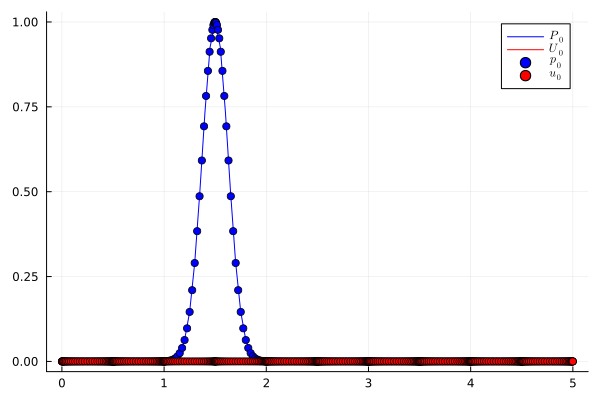

In [590]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot!(xreal,u0, color=:blue,seriestype=:scatter,label=L"u_0", format=:png)
plot(xx, pana0, color=:blue,label=L"P_0", format=:png)
plot!(xx, uana0, color=:red,label=L"U_0", format=:png)
#plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)
plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_0", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"u_0", format=:png)

In [591]:
#element real location boundaries
#xk

In [592]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);

In [593]:
elindex;

In [594]:
for k in 1:K
    #left boundary index
    lpoint = elindex[2*k-1]
    #right boundary index
    rpoint = elindex[2*k]
    println(lpoint,":", rpoint)
end

1:31
32:62
63:93
94:124
125:155
156:186
187:217
218:248
249:279
280:310


### Flux and Riemann Solver

Previously, we've only used the upwind scheme such that we find the characteristic variables $w^+$ & and $w^-$ and then multiply by the left $+$ and right $-$ eigenmatrix and diagonal:

\begin{align}
    F^* = \underline{P}\cdot \underline{\Lambda}^+ \cdot \bar{w}^+ + \underline{P}\cdot \underline{\Lambda}^- \cdot \bar{w}^-
\end{align}

Where, for this problem:

\begin{align}
    w^+ &= \frac{1}{2} \left(  \frac{p}{Z} + u  \right) \\
    w^- &= \frac{1}{2} \left(  -\frac{p}{Z} + u  \right)
\end{align}

In [595]:
#alg 88 NDG::NDG2DWaves
#UpwindScheme
function ReimannSolverNDG1DAcousticUpwind(QL::AbstractArray, QR::AbstractArray, normal::Float64, c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray)

    
    C=c[1]
    Rho = rho[1]
    pplus = QL[1]
    pminus = QR[1]
    uplus = QL[2]
    uminus = QR[2]

    F1 =  normal*C/2.0*(pplus + Rho*C*uplus - pminus + Rho*C*uminus)#normal*c/2.0*(pplus + Z*uplus - pminus + Z*uminus)
    F2 = normal*1.0/2.0/Rho*(pplus + Rho*C*uplus + pminus - Rho*C*uminus)#normal*c/2.0*(Zinv*pplus + uplus + Zinv*pminus - uminus)
    return [F1, F2]
end

ReimannSolverNDG1DAcousticUpwind (generic function with 1 method)

For discontinuities in materials such as density we need to calculate the numerical flux using the Rankin-Hugonoit Condition. 

In [596]:
#alg 88 NDG::NDG2DWaves
function ReimannSolverNDG1DRankineHugonoit(QL::AbstractArray, QR::AbstractArray, normal::Float64, c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray)

    cL = c[1]
    cR = c[2]
    rhoL = rho[1]
    rhoR = rho[2]
    kbulkL = kbulk[1]
    kbulkR = kbulk[2]
    ZL = rhoL*cL#/(rhoL*cL + rhoR*cR)#Z[1]#sqrt(n[1]*n[2])
    ZR = rhoR*cR#/(rhoL*cL + rhoR*cR)
    # #Zinv = 1.0/Z #nk2 = n[1]/2.0#*k[1]##*
    
    pL = QL[1]
    pR = QR[1]
    uL = QL[2]
    uR = QR[2]

    F1 = normal*(ZR*cL*(pL+ZL*uL) - ZL*cR*(pR-ZR*uR))/(ZR+ZL) #normal*c/2.0*(pplus + Z*uplus - pminus + Z*uminus)
    F2 = normal*(cL * (pL+ZL*uL) + cR* (pR-ZR*uR) )/(ZR+ZL)   #normal*c/2.0*(pplus + uplus + pminus - uminus)#normal*c/2.0*(Zinv*pplus + uplus + Zinv*pminus - uminus)

    return [F1, F2]
end

ReimannSolverNDG1DRankineHugonoit (generic function with 1 method)

In [597]:
#alg 64
function FluxAcoustic(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, n::AbstractArray, rhobulk::AbstractArray, c::AbstractArray)

    F[:,1] = rhobulk .* c.^2 .* Q[lpoint:rpoint, 2]#c^2 * Q[lpoint:rpoint, 2]#rhobulk[2] * Q[lpoint:rpoint, 2]
    F[:,2] = 1.0./ rhobulk .* Q[lpoint:rpoint, 1]#Q[lpoint:rpoint, 1] #1.0/rhobulk[1] * Q[lpoint:rpoint, 1]

    return nothing #F1, F2

end


FluxAcoustic (generic function with 1 method)

In [598]:
#alg 122 for boundary pointers
#create boundary pointers
eleft = append!([-1],[k for k in 1:K])
eright = append!([k for k in 1:K], [-1])
nodeleft = [Ntot for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPKD(eleft, eright, nodeleft, noderight);

In [599]:
# epk.eleft

In [600]:
# epk.eright

In [601]:
#external function
# ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
function ExtFunFreePropagationAcoustic(Qint::Array{Float64}, xyBoundary::Float64, xy::Float64, t::Float64, LRTB::String)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#Qint[1]#Fp(xy,t)## #Fp(xy,t)
        Qext[2] = 0.0#-Qint[2]#Fu(xy,t)#Fu(xy,t)# #Fu(xy,t)
        # Qext[3] = Fv(xyBoundary,xy,t)
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#0.0#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = 0.0#0.0#-Qint[2]#Fu(xy,t)#Fu0(xy,t)

    end
    return Qext
end

ExtFunFreePropagationAcoustic (generic function with 1 method)

In [602]:
#CFT Number
# ddxx = 5.0/(Ntot - K)
# CFT = 1.0
# ddtt = CFT/c*ddxx


In [603]:
dsema = deepcopy(dsem)
dt = 1.0e-3
ttot = 2.25
NT = floor(Int64, ttot/dt)


2250

In [604]:
tn = 0.0
for n in 0:NT

    if mod(n,20)==0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsema.G = 0
    @. dsema.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    DGSEMstep1DRK3!(dsema, epk, tn, dt, elindex, ExtFunFreePropagationAcoustic, ReimannSolverNDG1DRankineHugonoit, FluxAcoustic)
    tn = (n+1)*dt
    
    
end

Time Step: 2240


In [605]:
pt = Fp.(xx,dt*(NT+1))
ut = Fu.(xx,dt*(NT+1));

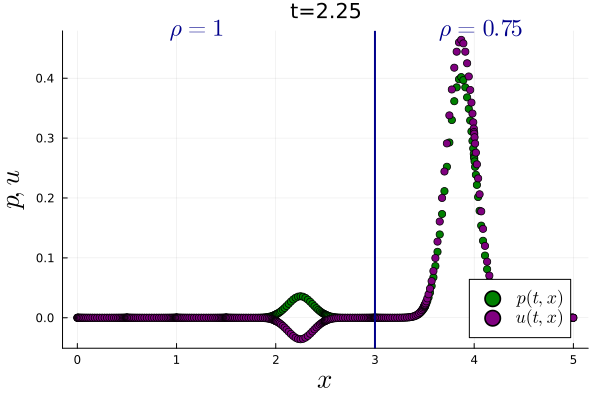

In [606]:
# plot(xx, pt, color=:blue,label=L"P_t", format=:png)
# plot!(xx, ut, color=:red,label=L"U_t", format=:png)
# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"p(t,x)", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"u(t,x)", format=:png)
vline!([3], color=:darkblue, linewidth=2, label="")
annotate!(1.5, 0.48, text(L"\rho = 1", :darkblue, :right, 16))
annotate!(4.5, 0.48, text(L"\rho = 0.75", :darkblue, :right, 16))
plot!(title="t=2.25", legend=:bottomright, legendfontsize=12)
xlabel!(L"x", guidefont=18)
ylabel!(L"p,u", guidefont=18)

# Maxwell's Equations

\begin{align}
    &\bar{D} = \epsilon(x) \bar{E} \\
    &\bar{H} = \frac{1}{\mu(x)} \bar{B} \\
    &\frac{\partial}{\partial t} \bar{D} + \bar{J}_f = \bar{\nabla}\times \bar{H} \\ 
    -&\frac{\partial}{\partial t} \bar{B}  = \bar{\nabla}\times \bar{E}
\end{align}

In 1D with wave travelling in the x-direction and E-field in y-direction, H-field in the z-direction: 

\begin{align}
    & D_y = \epsilon(x) E_y \\
    & H_z = \frac{1}{\mu(x)} B_z \\
    &\frac{\partial}{\partial t} D_y  = \frac{\partial}{\partial x} H_z\\ 
    -&\frac{\partial}{\partial t} B_z  = \frac{\partial}{\partial x} E_y
\end{align}

we can re-write this in vector-matrix notation

\begin{align}
    \left[ \begin{array}{cc} 
    \epsilon(x) && 0 \\
    0 && \mu(x)
    \end{array}\right]\cdot \frac{\partial}{\partial t} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]   + \left[ \begin{array}{cc} 
   0 && 1 \\
    1 && 0
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right] = 0
\end{align}

or 

\begin{align}
    \left[ \begin{array}{cc} 
    1 && 0 \\
    0 && 1
    \end{array}\right]\cdot \frac{\partial}{\partial t} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]   + \left[ \begin{array}{cc} 
   0 && \frac{1}{\epsilon(x)} \\
    \frac{1}{\mu(x)} && 0
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right] = 0
\end{align}

Which can be re-written as:

\begin{align}
    \underline{Q} \frac{\partial }{\partial t} \bar{q} + \underline{A} \frac{\partial }{\partial x} \bar{q} = 0
\end{align}


The Flux is given by $\underline{A}\cdot \bar{q}$

The relative permativity is written as:

\begin{align}
    \epsilon_r(x) &= \frac{\epsilon(x)}{\epsilon_0}\\
    &\Rightarrow  \epsilon(x) = \epsilon_0\cdot \epsilon_r(x)
\end{align}

and similarly for $\mu(x)$

We will abosrb the vacuum constants into the E-field and H-Field:

\begin{align}
    E_y &\Rightarrow \epsilon_0 E_y \\
    H_z &\Rightarrow \mu_0 H_z
\end{align}

## Implementation

In [636]:
#need to make a new struct
mutable struct DGmaxwell

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xreal::Array{Float64}
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::AbstractArray{Float64} #Low Storage RK3
    QLint::Array{Float64} # solution at left element boundaries
    QRint::Array{Float64} #solution at right element boundaries
    QLext::Array{Float64} # solution at left element boundaries
    QRext::Array{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    dF::AbstractArray{Float64} 
    FR::Array{Float64} #numerical flux on the right of elements
    FL::Array{Float64} #numerical flux on left of elements
    Qminus::AbstractArray{Float64} #flux
    Qplus::AbstractArray{Float64} #flux

    Dhat::AbstractArray #First derivative matrix in x
    c::AbstractArray{Float64}  #speed of wave in material
    Z::AbstractArray{Float64}  #impedance of wave in material
    epsr::AbstractArray{Float64}  #relative permattivity of material
    mur::AbstractArray{Float64}  #relative permeabiilty in material
    n::Vector{Float64} #Normal Vector
    
    lp1::AbstractArray #langrange interpolation at x=1 boundary
    ln1::AbstractArray #langrange interpolation at x=-1 boundary
    DGmaxwell() = new()

end

In [637]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstructMax(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  kvec::Array{Float64}, t::Float64, xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    NDG.n = kvec

    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        x, w = LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];

    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    
    #interpolation coefficients for l_j(+-1)
    ln1 = []
    lp1 = []
    for k in 1:K
        push!(ln1, LagrangeInterpolatingPolynomials(-1.0, xi[k],wkb[k],1.0e-12))
        push!(lp1, LagrangeInterpolatingPolynomials(1.0, xi[k],wkb[k],1.0e-12))
    end
    
    NDG.ln1 = ln1 #LagrangeInterpolatingPolynomials(-1.0, x,wb,1.0e-12)
    NDG.lp1 = lp1 #LagrangeInterpolatingPolynomials(1.0, x, wb,1.0e-12)

    #derivative matrix
    # Dx = PolynomialDerivativeMatrix(x)
    # NDG.Dhat = zeros(Float64, (size(Dx),K))
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for n in 0:N[k]
                nn = n+1 
                Dh[jj,nn] = -Dx[nn,jj]*wk[k][nn]/wk[k][jj]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.Dhat = Dhat;

    # for k in 2:K
    #     @. NDG.Dhat[:,:,k] = NDG.Dhat[:,:,1]
    # end

    #setting up initial conditions
    #calculate real positions
    #from affine map
    xreal = zeros(Float64, Ntot)
    # eps = zeros(Float64, Ntot)
    # mus = zeros(Float64, Ntot)
    # c = zeros(Float64, Ntot)
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0
        end

    end

    NDG.xreal = xreal

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] = Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.G = zeros(Float64, size(NDG.Q))

    NDG.F =zeros(Float64, (maximum(N)+1, Nvec))
    NDG.dF = zeros(Float64, (maximum(N)+1, Nvec))
    

    NDG.FR = zeros(Float64,(Nvec, K))
    NDG.FL = zeros(Float64,(Nvec,K))

    NDG.QRint = zeros(Float64, (Nvec,K))
    NDG.QRext = zeros(Float64, Nvec) #there's only one exteral point
    NDG.QLint = zeros(Float64, (Nvec,K))
    NDG.QLext = zeros(Float64,Nvec) # there's only one external point
    NDG.Qminus = zeros(Float64, (Nvec,Nvec))
    NDG.Qplus = zeros(Float64, (Nvec,Nvec))

    return xreal

end

NDGConstructMax (generic function with 2 methods)

The only other thing we need to change is our global derivative to take into account the change in $\epsilon(x)$

In [638]:
#Alg 92
#using eqn 5.152
function SystemDGSEMDerivative!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
    #construct flux derivative
    
    # for n in 1:Neqn 
    #     dF[:, n] .= Dhat * F[:,n]
    
    #     @. dF[:,n] =  dF[:,n] + (FR[n]*lp1  + FL[n]*ln1)/w
    # end
    dF[:, 1] .= Dhat * F[:,1]
    @. dF[:,1] =  dF[:,1] + (FR[1]*lp1  + FL[1]*ln1)/w
    dF[:, 2] .= Dhat * F[:,2]
    @. dF[:,2] =  dF[:,2] + (FR[2]*lp1  + FL[2]*ln1)/w

    return nothing


end

SystemDGSEMDerivative! (generic function with 1 method)

In [808]:
#alg 93
function DGSEM1DGlobalTimeDerivativeMax!(NDG::DGSEM, pk::EPKD, t::Float64,  eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn

    Q = @view(NDG.Q[:,:])
    # println("Size of Q: ", size(Q))
    # println("Starting Boundary Element Interpolation")
    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        # println("k: ", k)
        # println("Left:Right index: ", lpoint, ":", rpoint)
        for n in 1:Neqn
            
            NDG.QLint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.ln1[k])
            NDG.QRint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.lp1[k])
        end
    end
    # println("Starting External State")
    #ExternalState must return a vector size 3 which are the external values at the boundary
    #k <- p0.eright = 1
    kkk=1
    NDG.QLext[:] .= ExternalState(NDG.QLint[:,kkk], -1.0, NDG.xk[1], t, "LEFT")
    kkk=K
    NDG.QRext[:] .= ExternalState(NDG.QRint[:,kkk], 1.0, NDG.xk[end], t, "RIGHT")

    # println("Starting ReimannSolver")
    for k in 0:K
        kk=k+1
        #left boundary index
        idL = pk.eleft[kk]
        # lpoint = eindex[2*kk-1]
        #right boundary index
        idR = pk.eright[kk]
        # rpoint = eindex[2*k]

        if idL==-1
            lpoint = eindex[1]
            rpoint = eindex[1]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            #c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray
            #ReimannSolverNDG1DRHMax!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
            NDG.FL[:,idR] .= ReimannSolver(NDG.QLext, NDG.QLint[:,idR], -1.0, "LEFT",epsr, mur, c, Z)
        elseif idR == -1
            lpoint = eindex[end]
            rpoint = eindex[end]
            c = [NDG.c[rpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, "LEFT",epsr, mur, c, Z)
        else
            lpoint = eindex[2*kk-1]
            rpoint = eindex[2*kk]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "LEFT", epsr, mur, c, Z)
            NDG.FL[:,idR] .= -1.0 *. NDG.FR[:,idL]#ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "RIGHT", epsr, mur, c, Z)#-NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        end
        
    end
    
    # println("Starting Numerical Flux and System Derivative")

    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        
        #XFlux
        @. NDG.F = 0.0
        flux(NDG.F, NDG.Q, NDG.N[k], lpoint, rpoint, NDG.n, NDG.epsr[lpoint:rpoint], NDG.mur[lpoint:rpoint])
        # NDG.F[lpoint:rpoint,:] .= flux
        @. NDG.dF= 0.0
        SystemDGSEMDerivative!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])

        
        NDG.dQ[lpoint:rpoint, :] .= -2.0.*NDG.dF ./ NDG.dxk[k]
            
        
    end

    
end

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///dfs6/pub/ernestob/Julia/SpectralMethods/In[808]#69:36\[90mIn[808]:69:36[0;0m]8;;\
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "LEFT", epsr, mur, c, Z)
            NDG.FL[:,idR] .= -1.0 *[48;2;120;70;70m.[0;0m NDG.FR[:,idL]#ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "RIGHT", epsr, mur, c, Z)#-NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
[90m#                                  ╙ ── [0;0m[91minvalid identifier[0;0m

In [809]:
# #alg 62
function DGSEMstep1DRK3Max!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        DGSEM1DGlobalTimeDerivativeMax!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK3Max! (generic function with 2 methods)

For the Riemann Solver we need to find the following eigen solutions

We because the discontinuity is piecewise we will use the Rankine-Hugoniot condition which is as follows:

\begin{align}
    &\lambda^- \underline{Q}^- \left( \bar{q}^* - \bar{q}^- \right) + \left[ \left(\underline{\Pi} \bar{q}\right)^* -  \left(\underline{\Pi} \bar{q}\right)^-  \right] = 0 \\
    &\lambda^+ \underline{Q}^+ \left( \bar{q}^{**} - \bar{q}^+ \right) + \left[ \left(\underline{\Pi} \bar{q}\right)^{**} -  \left(\underline{\Pi} \bar{q}\right)^+  \right] = 0 
\end{align}

with the assumption that the numerical fluxes are the same $\left(\underline{\Pi} \bar{q}\right)^{*} = \left(\underline{\Pi} \bar{q}\right)^{**}$ since we are calculating the flux through a surface. Then:

\begin{align}
    \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^-     \right)\left(\underline{\Pi} \bar{q}\right)^* = 
    \lambda^+ \underline{Q}^+ \left(\underline{\Pi} \bar{q}\right)^- + \lambda^- \underline{Q}^- \left(\underline{\Pi} \bar{q}\right)^+ + c^- c^+ \underline{Q}^- \underline{Q}^+ \left( \bar{q}^- - \bar{q}^+  \right)
\end{align}

where the $+,-$ superscripts denote the outgoing and incoming wave from normal, respectively

Here: $\left(\underline{A} \bar{q}\right)^{*}$ is the numerical flux, $\left(\underline{A} \bar{q}\right)^{\pm}$ is the outgoing and incoming flux and we need to find:

\begin{align}
    \left( \underline{\Pi} \bar{q} \right)^{\pm,*} = \hat{n} \cdot \left(  \underline{A} \bar{q} \right)^{\pm,*} = \hat{n} \cdot \left[ \begin{array}{cc} 
    H_z^{\pm,*} \\
    E_y^{\pm,*}
    \end{array}\right]
\end{align}

We then need to find the eigenvalues of the matrix $\underline{A}$

\begin{align}
    \underline{A} = \left[ \begin{array}{cc} 
    0 && \frac{1}{\epsilon_r(x)}  \\
    \frac{1}{\mu_r(x)}  && 0
    \end{array}\right]
\end{align}


With Eigenvalues: 

\begin{align}
    \lambda_1 &= \frac{1}{\sqrt{\mu \: \epsilon}} = c\\
    \lambda_2 &= -c
\end{align}

and the eigenvectors: 

\begin{align}
    \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} \\
    1
    \end{array}\right], \:\:\:  \left[ \begin{array}{cc} 
    -\sqrt{\mu / \epsilon} \\
    1
    \end{array}\right]
\end{align}

and we define the impedance $Z = \sqrt{\mu / \epsilon}$

Then we should find an inversion for the sum of the matrices: $ \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- $ where the $\pm$ represent the outgoing/incoming waves.

\begin{align}
    \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- &= \left[ \begin{array}{cc} 
    c^+ + c^-  && 0 \\
    0 && -c^+ - c^- 
    \end{array}\right] 
\end{align}

Then the inverse becomes:

\begin{align}
     \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- \right)^{-1} = \left[ \begin{array}{cc} 
    \frac{1}{c^+ + c^-} && 0 \\
    0 && -\frac{1}{c^+ + c^-}
    \end{array}\right] 
\end{align}


We then need to find the eigenvalues of the matrix $\underline{Q}^{-1} \underline{A}$

\begin{align}
    \underline{Q}^{-1} = \left[ \begin{array}{cc} 
    \frac{1}{\epsilon(x)} && 0 \\
    0 && \frac{1}{\mu(x)}
    \end{array}\right]
\end{align}

\begin{align}
    \underline{Q}^{-1}\underline{A} = \left[ \begin{array}{cc} 
    0 && \frac{1}{\epsilon(x)}  \\
    \frac{1}{\mu(x)}  && 0
    \end{array}\right]
\end{align}


With Eigenvalues: 

\begin{align}
    \lambda_1 &= \frac{1}{\sqrt{\mu \: \epsilon}} = c\\
    \lambda_2 &= -c
\end{align}

and the eigenvectors: 

\begin{align}
    \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} \\
    1
    \end{array}\right], \:\:\:  \left[ \begin{array}{cc} 
    -\sqrt{\mu / \epsilon} \\
    1
    \end{array}\right]
\end{align}

and we define the impedance $Z = \sqrt{\mu / \epsilon}$

Then we should find an inversion for the sum of the matrices: $ \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- $

\begin{align}
    \lambda^{\pm} &= \left[ \begin{array}{cc} 
    c^{\pm}  && 0 \\
    0 && -c^{\pm}
    \end{array}\right]
\end{align}

\begin{align}
    \underline{Q}^{\pm} &= \left[ \begin{array}{cc} 
    \epsilon^{\pm}  && 0 \\
    0 && \mu^{\pm}
    \end{array}\right]
\end{align}


so then:

\begin{align}
    \lambda^{\pm}\cdot\underline{Q}^{\pm} &= \left[ \begin{array}{cc} 
    c^{\pm} \epsilon^{\pm}  && 0 \\
    0 && -c^{\pm} \mu^{\pm}
    \end{array}\right]
\end{align}


\begin{align}
    \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- &= \left[ \begin{array}{cc} 
    c^+ \epsilon^+ + c^- \epsilon^- && 0 \\
    0 && -c^+ \mu^+ - c^- \mu^-
    \end{array}\right] \\
    &\Rightarrow \left[ \begin{array}{cc} 
    \sqrt{\epsilon^+/\mu^+} + \sqrt{\epsilon^-/\mu^-} && 0 \\
    0 && -\sqrt{\mu^+/\epsilon^+} - \sqrt{\mu^-/\epsilon^-} 
    \end{array}\right] \\
    &\Rightarrow \left[ \begin{array}{cc} 
    1/Z^+ + 1/Z^- && 0 \\
    0 && -Z^+ - Z^-
    \end{array}\right]
\end{align}

Then the inverse becomes:

\begin{align}
     \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- \right)^{-1} = \left[ \begin{array}{cc} 
    \frac{Z^+ Z^-}{Z^+ + Z^-} && 0 \\
    0 && \frac{-1}{Z^+ + Z^-}
    \end{array}\right] 
\end{align}

In [810]:
# #alg 88 NDG::NDG2DWaves
# function ReimannSolverNDG1D(QL::AbstractArray, QR::AbstractArray,  normal::Float64, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray, Qminus::AbstractArray, Qplus::AbstractArray)
#     #Qout - outgoing corresponds to +
#     #Qinc - incoming wave corresponds to -
#     #normal is normal to x surface
#     #epsr - [1] is incoming eps and [2] is outgoing
    
#     ZL = Z[1]
#     ZR = Z[2]
#     cL = c[1]
#     cR = c[2]
#     epsrL = epsr[1]
#     epsrR = epsr[2]
#     murL = mur[1]
#     murR = mur[2]

#     EL = QL[1]
#     HL = QL[2]
#     ER = QR[1]
#     HR = QR[2]

#     #make Q- and Q+
#     Qplus[1,1] = epsr[2]#cplus*epsr[1]
#     Qplus[1,2] = 0.0
#     Qplus[2,1] = 0.0
#     Qplus[2,2] = mur[2]#-cplus*mur[1]
#     Qminus[1,1] = epsr[1]#cminus*epsr[2]
#     Qminus[1,2] = 0.0
#     Qminus[2,1] = 0.0
#     Qminus[2,2] = mur[1]#-cminus*mur[2]
    
    
#     Fnum = cplus * (Qplus * (normal.*[Qminc[2], Qminc[1]]))
#     Fnum = Fnum + cminus * (Qminus * (normal.*[Qpout[2], Qpout[1]]))
#     Fnum = Fnum + cplus*cminus * (Qminus * (Qplus * (Qminc - Qpout)))
#     # Fnum = Fnum - cplus*cminus * (Qminus * (Qplus * Qpout))

#     Fnum[1] = Fnum[1] * (Zplus*Zminus)/(Zplus+Zminus)
#     Fnum[2] = Fnum[2]/(Zplus+Zminus)

#     return Fnum
    

# end

In [811]:
# #alg 88 NDG::NDG2DWaves
# function ReimannSolverNDG1DRankineHugonoit(QL::AbstractArray, QR::AbstractArray, normal::Float64, c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray)

#     cL = c[1]
#     cR = c[2]
#     rhoL = rho[1]
#     rhoR = rho[2]
#     kbulkL = kbulk[1]
#     kbulkR = kbulk[2]
#     ZL = rhoL*cL#/(rhoL*cL + rhoR*cR)#Z[1]#sqrt(n[1]*n[2])
#     ZR = rhoR*cR#/(rhoL*cL + rhoR*cR)
#     # #Zinv = 1.0/Z #nk2 = n[1]/2.0#*k[1]##*
    
#     pL = QL[1]
#     pR = QR[1]
#     uL = QL[2]
#     uR = QR[2]

#     F1 = normal*(ZR*cL*(pL+ZL*uL) - ZL*cR*(pR-ZR*uR))/(ZR+ZL) #normal*c/2.0*(pplus + Z*uplus - pminus + Z*uminus)
#     F2 = normal*(cL * (pL+ZL*uL) + cR* (pR-ZR*uR) )/(ZR+ZL)   #normal*c/2.0*(pplus + uplus + pminus - uminus)#normal*c/2.0*(Zinv*pplus + uplus + Zinv*pminus - uminus)

#     return [F1, F2]
# end

In [812]:
typeof("h")

String

With an initial values of:

\begin{align}
    E_0 &= 2^{ -\frac{(x-1)^2}{b^2}   } \\
    H_0 &= \frac{E_0}{Z_0} 
\end{align}

The method of Characteristics tells us that $x \rightarrow x(x_0, t) = x_0 + \lambda t$

\begin{align}
    w^+_0 = \frac{1}{2} \left( \frac{E_0}{Z} + H_0  \right)= \frac{1}{Z} 2^{ -\frac{(x-1)^2}{b^2}   }
\end{align}

\begin{align}
    w^+ = w^+_0(x \rightarrow x(x_0, t) = x_0 - c t) = \frac{1}{Z} 2^{ -\frac{(x - c t -1)^2}{b^2}   }
\end{align}

Similarly:

\begin{align}
    w^-_0 = \frac{1}{2} \left( -\frac{E_0}{Z} + H_0  \right) = 0
\end{align}

\begin{align}
    w^- = w^-_0(x \rightarrow x(x_0, t) = x_0 + c t) = 0 =-\frac{1}{2 Z} 2^{ -\frac{(x + c t -1)^2}{b^2}   }
\end{align}



So then the analytical solution is:

\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]  = \underline{P}\cdot \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    Z && -Z \\
    1 && 1
    \end{array}\right] \cdot  \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \frac{1}{2} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} + 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)  \\
    \frac{1}{2 Z} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} - 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)
    \end{array}\right] 
\end{align}

Which we use calculate the external flux. Is this necessary? Is it necessary for waves moving through different material?

In [813]:
t0 = 0.0
mu0 = 1.0
mu1 = 1.0
eps0 = 1.0 #vacuum relative permittivity
eps1 = 4.0 #material relative permittivity
xeps = 3.0 #position of material boundary
c0 = 1.0/sqrt(eps0*mu0) #relative wave speed in vacuum
c1 = 1.0/sqrt(eps1*mu1)
Z0 = sqrt(mu0/eps0)
Z1 = sqrt(mu1/eps1)
X0 = 2.0 #center of wave at t=0
tau = 0.2 #fwhm

#x will be scaled by wavelength x/lambda -> x
#time will be scaled by frequency t*f -> f
#so wavelength must also
c0 ,c1


(1.0, 0.5)

In [883]:
function speedc(x::Float64, xeps=xeps)
    c = 0.0
    if x <= xeps
        c = c0#1.0/sqrt(epsr*mur)
    else
        c = c1
    end
    return c
end

function impZ(x::Float64, xeps=xeps)
    Z = 0.0
    if x <= xeps
        Z = Z0#1.0/sqrt(epsr*mur)
    else
        Z = Z1
    end
    return Z
end

#time is scaled by c -> c=1 so 

Fe(x,t) = 0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))# + 2^(-((x-X0) + speedc(x)*t)^2/b^2))#2.0^(-(x-X0)^2/b^2) #
#Fu0(x,t) = 0.0#1.0/c * Fp0(x,t)#kx/omega*exp(-(kx*(x-1.0) -omega*t)^2/b^2) 
Fh(x,t) = 0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))# - 2^(-((x-X0) + speedc(x)*t)^2/b^2))
Fun = [Fe, Fh]

2-element Vector{Function}:
 Fe (generic function with 1 method)
 Fh (generic function with 1 method)

We must benchmark with theoretical solution. 

The initial incident waves travelling to the right that hit the interface are: 

\begin{align}
    E_I &= \tilde{E}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_I &= \tilde{H}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{I0} &= \frac{1}{2} 2^{ -\frac{(x -c_0 t -1)^2}{b^2}} \\
    \tilde{H}_{I0} &= \frac{1}{2 Z}  2^{ -\frac{(x -c_0 t -1)^2}{b^2}}
\end{align}


On the left, $\epsilon_1 = 1.0$ and on the right $\epsilon_2 = 1.7$ and $\mu_L = \mu_R = 1.0$

When the incident wave hits the interface, a reflected and transmitted wave are created. 

We use the solution given by Griffiths. According to Griffiths 

\begin{align}
    E_R &= \tilde{E}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_R &= -\tilde{H}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

and

\begin{align}
    E_T &= \tilde{E}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} \\
    H_T &= \tilde{H}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} 
\end{align}



Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{R0} &= R \cdot \tilde{E}_{I0} \\
    \tilde{H}_{R0} &= \frac{1}{Z_0} \tilde{E}_{R0}
\end{align}

\begin{align}
    \tilde{E}_{T0} &= T \cdot \tilde{E}_{I0} \\
    \tilde{H}_{T0} &= \frac{1}{Z_1} \tilde{E}_{T0}
\end{align}

$R$ and $T$ are the reflection and transmission coefficeints 

Eqn 81 we have: 

\begin{align}
    \beta = \frac{Z_0}{Z_1}
\end{align}

And the amplitudes for the reflected and transmitted waves: 

\begin{align}
    \tilde{E}_{R0} &= \frac{1-\beta}{1+\beta} \tilde{E}_{I0}\\
    \tilde{E}_{T0} &= \frac{2}{1+\beta} \tilde{E}_{I0}
\end{align}

In [884]:
Beta = Z0/Z1

2.0

In [885]:
ERef = (1-Beta)/(1+Beta)

-0.3333333333333333

In [886]:
ERef/Z0

-0.3333333333333333

In [887]:
ETran = 2.0/(1+Beta)

0.6666666666666666

In [888]:
ETran/Z1

1.3333333333333333

In [889]:
function FeI(x,t)
    FE = 0.0
    if x <= xeps
        FE = 0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2) + 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhI(x,t)
    FH = 0.0
    if x <= xeps
        FH = 0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhI (generic function with 1 method)

In [890]:
function FeR(x,t)
    FE = 0.0
    if x <= xeps
        FE = ERef*0.5*( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhR(x,t)
    FH = 0.0
    if x < xeps
        FH = -ERef*0.5/impZ(x) *( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhR (generic function with 1 method)

In [891]:
function FeT(x,t)
    FE = 0.0
    if x >= xeps
        FE = ETran*0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhT(x,t)
    FH = 0.0
    if x >= xeps
        FH = ETran*0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhT (generic function with 1 method)

In [892]:
Z0

1.0

In [893]:
Z1

0.5

In [894]:
c1

0.5

In [895]:
speedc(3.2)

0.5

In [896]:
kvec = [1.0, -1.0]
xtot = [0.0, 5.0]
Nvec = 2
K = 50
NN = 8
N = [NN for i in 1:K]
Ntot = sum(N.+1)
dxk = (xtot[2]-xtot[1])/K
xk = [dxk*i for i in 0:K];

In [897]:
#make struct
DGSEM = DGmaxwell
dsem = DGSEM()

DGmaxwell(#undef, 140488377241608, 140486755495952, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

In [898]:
xreal = NDGConstructMax(dsem, N, K, "leg", Nvec, Fun, kvec, t0,  xk);
#NDGConstruct(dsem, N, K, "leg", Nvec, Fun,  c, rho, Kbulk, kvec, t0,  xk);
# NDGConstructMax(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  c::AbstractArray, epsr::AbstractArray, mur::AbstractArray, kvec::Array{Float64}, t::Float64,  xk::AbstractArray)

In [899]:
#need to construct arrays for eps, mu, and c
epsr = zeros(Float64, length(xreal))
mur = zeros(Float64, length(xreal))
c = zeros(Float64, length(xreal))
Z = zeros(Float64, length(xreal))

for i in 1:length(c)
    if xreal[i] <= xeps
        epsr[i] = eps0
        mur[i] = mu0
        c[i] = c0
        Z[i] = Z0
    elseif xreal[i] > xeps
        epsr[i] = eps1
        mur[i] = mu1
        c[i] = c1
        Z[i] = Z1
    end

end

In [900]:
dsem.epsr = epsr
dsem.mur = mur
dsem.c = c;
dsem.Z = Z;

In [901]:
xx = [0.0 + i*xtot[end]/100 for i in 0:100]
Eana0 = Fe.(xx,0.0);
Hana0 = Fh.(xx,0.0);
E0 = Fe.(xreal,0.0);
H0 = Fh.(xreal,0.0);

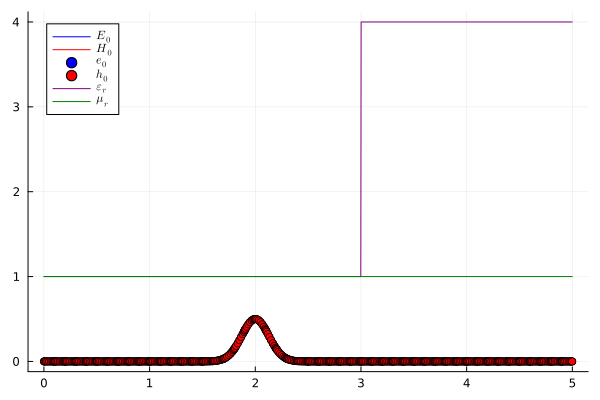

In [902]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot!(xreal,u0, color=:blue,seriestype=:scatter,label=L"u_0", format=:png)
plot(xx, Eana0, color=:blue,label=L"E_0", format=:png)
plot!(xx, Hana0, color=:red,label=L"H_0", format=:png)
# plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)

plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"e_0", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"h_0", format=:png)
plot!(xreal, epsr, color=:purple,label=L"\epsilon_r", format=:png)
plot!(xreal, mur, color=:green,label=L"\mu_r", format=:png)

In [903]:
#element real location boundaries
xk;

In [904]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);

In [905]:
elindex;

In [906]:
# for k in 1:K
#     #left boundary index
#     lpoint = elindex[2*k-1]
#     #right boundary index
#     rpoint = elindex[2*k]
#     println(lpoint,":", rpoint)
# end

In [907]:
#alg 122 for boundary pointers
#create boundary pointers
eleft = append!([-1],[k for k in 1:K])
eright = append!([k for k in 1:K], [-1])
nodeleft = [Ntot for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPKD(eleft, eright, nodeleft, noderight);

In [908]:
epk.eleft;

In [909]:
epk.eright;

In [928]:
#alg 88 NDG::NDG2DWaves
# ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, "LEFT", c, epsr, mur, Z)
function ReimannSolverNDG1DRHMax!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, side::String, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
    #Qout - outgoing corresponds to +
    #Qinc - incoming wave corresponds to -
    #normal is normal to x surface
    #epsr - [1] is incoming eps and [2] is outgoing
    
    ZL = Z[1]
    ZR = Z[2]
    cL = c[1]
    cR = c[2]
    epsL = epsr[1]
    epsR = epsr[2]
    muL = mur[1]
    muR = mur[2]

    EL = QL[1]
    HL = QL[2]
    ER = QR[1]
    HR = QR[2]

    F1 = 0.0
    F2 = 0.0
    
    # FLstar
    if side == "LEFT"
        F1 = normal*( ZR*cL*(EL + ZL*HL) - ZL*cR*(ER - ZR*HR) )/((ZL+ZR)) 
        F2 = normal*(cL*(EL + HL*ZL) + cR*(ER - ZR*HR))/((ZL+ZR))
    elseif side == "RIGHT"
        F1 = -normal*( ZR*cL*(EL + ZL*HL) - ZL*cR*(ER - ZR*HR) )/((ZL+ZR))  
        F2 = -normal*(cL*(EL + HL*ZL) + cR*(ER - ZR*HR))/((ZL+ZR))
    end

    return [F1, F2] #[FLstar1, FLstar2], [FRstar1, Fstar2]
    

end

ReimannSolverNDG1DRHMax! (generic function with 1 method)

In [929]:
#alg 64
function FluxMaxwell(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, n::AbstractArray, epsr::AbstractArray, mur::AbstractArray)

    F[:,1] = 1.0 ./ epsr .* Q[lpoint:rpoint, 2]#c^2 * Q[lpoint:rpoint, 2]#rhobulk[2] * Q[lpoint:rpoint, 2]
    F[:,2] = 1.0 ./ mur .* Q[lpoint:rpoint, 1]#Q[lpoint:rpoint, 1] #1.0/rhobulk[1] * Q[lpoint:rpoint, 1]

    return nothing #F1, F2

end


FluxMaxwell (generic function with 1 method)

In [930]:
#external function
# ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
function ExtFunFreePropagation(Qint::Array{Float64}, xyBoundary::Float64, xy::Float64, t::Float64, LRTB::String)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#FeI(xy,t) + FeR(xy,t)#0.0#Fp(xy,t)#Qint[1] #Fp(xy,t)
        Qext[2] = 0.0#FhI(xy,t) + FhR(xy,t)#0.0Fu(xy,t)#-Qint[2] #Fu(xy,t)
        # Qext[3] = Fv(xyBoundary,xy,t)
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#FeT(xy,t)#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = 0.0#FhT(xy,t)#-Qint[2]#Fu(xy,t)#Fu0(xy,t)
    end
    return Qext
end

# EI = FeI.(xx,tt)
# HI = FhI.(xx,tt);
# ER = FeR.(xx,tt)
# HR = FhR.(xx,tt);
# ET = FeT.(xx,tt)
# HT = FhT.(xx,tt);

ExtFunFreePropagation (generic function with 1 method)

In [931]:
#CFT Number
ddxx = 5.0/(Ntot - K)
CFT = 1.0
ddtt = CFT/c1*ddxx


0.025

In [932]:
dsema = deepcopy(dsem)
dt = 5.0e-4
ttot = 2.0
NT = floor(Int64, ttot/dt)


4000

In [933]:
tn = 0.0
for n in 0:NT
    if mod(n,100) == 0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsema.G = 0
    @. dsema.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    #ReimannSolverNDG1D
    DGSEMstep1DRK3Max!(dsema, epk, tn, dt, elindex, ExtFunFreePropagation, ReimannSolverNDG1DRHMax!, FluxMaxwell)
    tn = (n+1)*dt
    
    
end

Time Step: 4000


In [934]:
dsema.Q[1,1]

-1.0482254937851003e-16

In [935]:
tt = ttot
EI = FeI.(xx,tt)
HI = FhI.(xx,tt);
ER = FeR.(xx,tt)
HR = FhR.(xx,tt);
ET = FeT.(xx,tt)
HT = FhT.(xx,tt);

EE = @. EI+ER+ET
HH = @. HI+HR+HT;

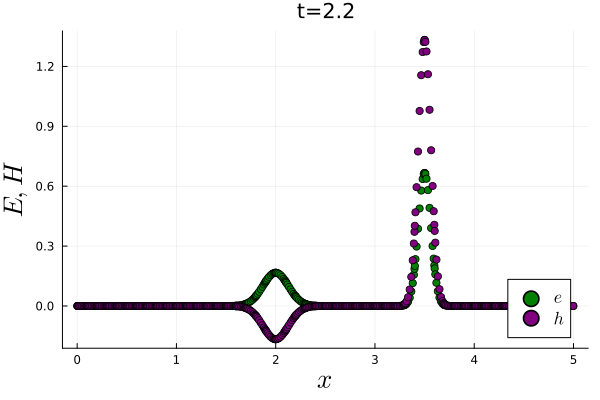

In [973]:

# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h", format=:png)
# plot!(xx, EE, color=:blue,label=L"E", linewidth=2.0,format=:png)
# plot!(xx, HH, color=:red,label=L"H", linewidth=2.0,format=:png)
# vline!([3], color=:darkblue, linewidth=2, label="")
# annotate!(1.5, 0.5, text(L"\epsilon_r = 1", :darkblue, :right, 16))
# annotate!(4.5, 0.5, text(L"\epsilon_r = 1.25", :darkblue, :right, 16))
# annotate!(1.3, -0.3, text("Left wave", :black, :right, 10))
# annotate!(1.8, 0.2, text("Reflected wave\n"*L"|E_R|=0.14 \: E_I", :black, :left, 10))
# annotate!(3.1, -0.1, text("Transmitted wave\n"*L"|E_T|=0.85 \: E_I", :black, :left, 10))
# plot!(xreal, epsr, color=:purple,label=L"\epsilon_r", format=:png)
# plot!(xreal, mur, color=:green,label=L"\mu_r", format=:png)
plot!(title="t=2.2", legend=:bottomright, legendfontsize=12)#, xlim=(3.0,4.0), ylim=(0,1.35))
# vline!([3], color=:darkblue, linewidth=2, label="")
# hline!([0.675], color=:darkblue, linewidth=2, label="")
# vline!([3.425], color=:darkblue, linewidth=2, label="")
# vline!([3.575], color=:darkblue, linewidth=2, label="")

xlabel!(L"x", guidefont=18)
ylabel!(L"E,H", guidefont=18)


In [972]:
1.35/2

0.675

In [ ]:
.3

In [971]:
0.15

0.15

In [950]:
0.175/2.0

0.0875

In [850]:
Z0/Z1

2.0

In [689]:
X0

2.0

In [690]:
ERef

-0.3333333333333333

In [691]:
ETran

0.6666666666666666

In [3599]:
c0*ttot

2.2

In [3600]:
c1*ttot

1.967739820199815

In [3584]:
maximum((dsema.Q[:,1]))

0.47270922756914535

In [3585]:
maximum((dsema.Q[:,2]))

0.4825932284629805

In [692]:
0.5*ETran

0.3333333333333333

In [975]:
0.5*ETran/Z1

0.6666666666666666

In [3509]:
0.5*ETran/Z1/maximum((dsema.Q[:,2]))

0.8960727898804876

In [3510]:
Z1/Z0

0.8944271909999159

In [3503]:
maximum(EE)

0.4675807813773784

In [3504]:
maximum(HH)

0.5227712060661429

In [3501]:
maximum(abs.(dsema.Q[1:200,2]))

0.14208608513183651

In [2803]:
maximum(EE)*ETran

0.42910840203247674

In [2804]:
maximum(EE)*ETran/Z1

0.47975777833046346

In [3464]:
dsema.Q[1,1]

NaN

In [3465]:
length(EE)

101

In [3466]:
minimum(EE[30:60])

-0.02786404500042062

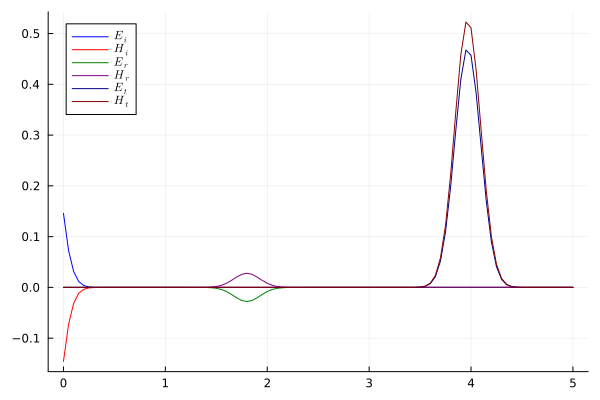

In [3467]:
plot(xx, EI, color=:blue,label=L"E_i", format=:png)
plot!(xx, HI, color=:red,label=L"H_i", format=:png)
plot!(xx, ER, color=:green,label=L"E_r", format=:png)
plot!(xx, HR, color=:purple,label=L"H_r", format=:png)
plot!(xx, ET, color=:darkblue,label=L"E_t", format=:png)
plot!(xx, HT, color=:darkred,label=L"H_t", format=:png)

In [2805]:
length(dsema.Q[:,1])

450

In [2806]:
maximum(dsema.Q[200:end,1]), maximum(dsema.Q[200:end,2])

(0.4959089034162212, 0.5544430093430239)

In [2668]:
# plot(xx, Eana0, color=:blue,label=L"E_0", format=:png)
# plot!(xx, Hana0, color=:red,label=L"E_0", format=:png)
# plot!(xx, pt, color=:green,label=L"E_t", format=:png)
# plot!(xx, ut, color=:purple,label=L"H_t", format=:png)
# # plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
# plot!(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e_t", format=:png)
# plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h_t", format=:png)

We must benchmark with theoretical solution. 

The initial incident waves travelling to the right that hit the interface are: 

\begin{align}
    E_I &= \tilde{E}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_I &= \tilde{H}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{I0} &= \frac{1}{2} 2^{ -\frac{(x -c_0 t -1)^2}{b^2}} \\
    \tilde{H}_{I0} &= \frac{1}{2 Z}  2^{ -\frac{(x -c_0 t -1)^2}{b^2}}
\end{align}


On the left, $\epsilon_1 = 1.0$ and on the right $\epsilon_2 = 1.7$ and $\mu_L = \mu_R = 1.0$

When the incident wave hits the interface, a reflected and transmitted wave are created. 

We use the solution given by Griffiths. According to Griffiths 

\begin{align}
    E_R &= \tilde{E}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_R &= -\tilde{H}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

and

\begin{align}
    E_T &= \tilde{E}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} \\
    H_T &= \tilde{H}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} 
\end{align}



Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{R0} &= R \cdot \tilde{E}_{I0} \\
    \tilde{H}_{R0} &= \frac{1}{Z_0} \tilde{E}_{R0}
\end{align}

\begin{align}
    \tilde{E}_{T0} &= T \cdot \tilde{E}_{I0} \\
    \tilde{H}_{T0} &= \frac{1}{Z_1} \tilde{E}_{T0}
\end{align}

$R$ and $T$ are the reflection and transmission coefficeints 

Eqn 81 we have: 

\begin{align}
    \beta = \frac{Z_0}{Z_1}
\end{align}

And the amplitudes for the reflected and transmitted waves: 

\begin{align}
    \tilde{E}_{R0} &= \frac{1-\beta}{1+\beta} \tilde{E}_{I0}\\
    \tilde{E}_{T0} &= \frac{2}{1+\beta} \tilde{E}_{I0}
\end{align}

In [2872]:
Beta = Z0/Z1

1.118033988749895

In [2873]:
ERef = (1-Beta)/(1+Beta)

-0.05572809000084124

In [2874]:
ETran = 2.0/(1+Beta)

0.9442719099991588

In [2875]:
ETran/Z1

1.0557280900008412

In [2876]:
function FeI(x,t)
    FE = 0.0
    if x < xeps
        FE = 0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2) + 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhI(x,t)
    FH = 0.0
    if x < xeps
        FH = 0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhI (generic function with 1 method)

In [2877]:
function FeR(x,t)
    FE = 0.0
    if x < xeps
        FE = ERef*0.5*( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhR(x,t)
    FH = 0.0
    if x < xeps
        FH = -ERef*0.5/impZ(x) *( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhR (generic function with 1 method)

In [2878]:
function FeT(x,t)
    FE = 0.0
    if x >= xeps
        FE = ETran*0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhT(x,t)
    FH = 0.0
    if x >= xeps
        FH = ETran*0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhT (generic function with 1 method)

In [2717]:
tt = 0.5
EI = FeI.(xx,tt)
HI = FhI.(xx,tt);
ER = FeR.(xx,tt)
HR = FhR.(xx,tt);
ET = FeT.(xx,tt)
HT = FhT.(xx,tt);

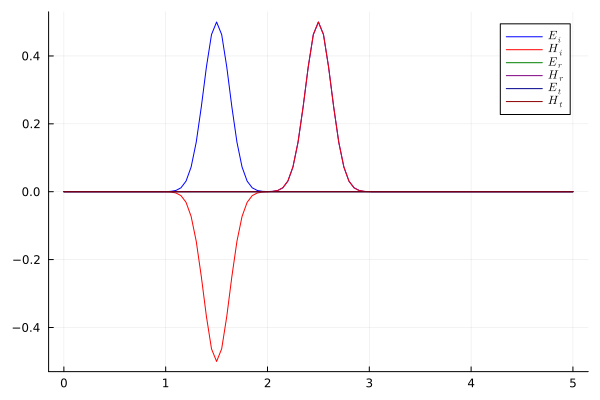

In [2719]:
plot(xx, EI, color=:blue,label=L"E_i", format=:png)
plot!(xx, HI, color=:red,label=L"H_i", format=:png)
plot!(xx, ER, color=:green,label=L"E_r", format=:png)
plot!(xx, HR, color=:purple,label=L"H_r", format=:png)
plot!(xx, ET, color=:darkblue,label=L"E_t", format=:png)
plot!(xx, HT, color=:darkred,label=L"H_t", format=:png)
# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
# plot!(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e_t", format=:png)
# plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h_t", format=:png)

In [2720]:
maximum(EI)

0.5000000000000209

In [2721]:
maximum(HI)

0.49999999999997913

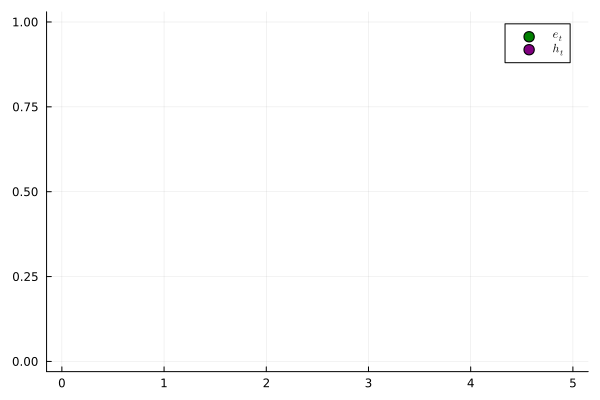

In [1495]:
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e_t", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h_t", format=:png)

In [1206]:

#LegendreNDG1DWave!(dsema, epk, NT, dt, 1, elindex, ExtFunFreePropagation, ReimannSolverNDG1D, Flux)

In [2226]:
dsema.Q[1,1]

NaN

Again we do the eigen analysis to diagonalize our equation:

\begin{align}
    \underline{S} = \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} && -\sqrt{\mu / \epsilon} \\
    1 && 1
    \end{array}\right]
\end{align}

and

\begin{align}
    \underline{S}^{-1} = \frac{1}{2} \left[ \begin{array}{cc} 
    \sqrt{\epsilon / \mu } && 1  \\
    -\sqrt{\epsilon / \mu} && 1
    \end{array}\right]
\end{align}

\begin{align}
    \underline{\Lambda}^+ = \left[ \begin{array}{cc} 
    c && 0 \\
    0 && 0
    \end{array}\right]
\end{align}

\begin{align}
    \underline{\Lambda}^- = \left[ \begin{array}{cc} 
    0 && 0 \\
    0 && -c
    \end{array}\right]
\end{align}

Using $Z = \sqrt{\mu / \epsilon}$

Also note that both $\mu$, $\epsilon$, and $c$ change with respect to position and therefore change with respect to which side of the surface boundary they're at

\begin{align}
    \underline{S}^{-1} \cdot \bar{q} =  \frac{1}{2} \left[ \begin{array}{cc} 
   \frac{1}{Z^+}\cdot E_y + H_z  \\
    \frac{-1}{Z^-}\cdot E_y + H_z 
    \end{array}\right] = \frac{1}{2}  \left[ \begin{array}{cc} 
   w^+\\
    w^-
    \end{array}\right]
\end{align}


\begin{align}
    \underline{\Lambda}^{+} \cdot \underline{S}^{-1} \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   c^+ \cdot w^+\\
    0
    \end{array}\right]
\end{align}


\begin{align}
    \underline{\Lambda}^{-} \cdot \underline{S}^{-1} \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   0\\
    -c^- \cdot w^-
    \end{array}\right]
\end{align}

\begin{align}
    F^* = \left( \underline{S} \cdot \underline{\Lambda}^{+} \cdot \underline{S}^{-1} +   \underline{S} \cdot\underline{\Lambda}^{-} \cdot \underline{S}^{-1}  \right)  \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   Z \left( w^+ + w^-  \right) \\
    w^+ - w^-
    \end{array}\right] = \frac{c}{2} \left[ \begin{array}{cc} 
     E^+_y + Z\: H_z^+ - E_y^- + Z\: H_z^-   \\
    \frac{E_y^+}{Z} + H_z^+ + \frac{E_y^-}{Z} - H_z^- 
    \end{array}\right]
\end{align}

In [1016]:
#alg 116
mutable struct DSEM1D

    N::Int64
    K::Int64
    xi::Array{Float64} #node locations
    wk::Array{Float64} #Gauss-Lobatto quad weights
    wbk::Array{Float64} #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xkL::Array{Float64} #left boundary of elements
    xkR::Array{Float64} #Right boundary of elements
    Q::Array{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::Array{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::Array{Float64} #Low Storage RK3
    QL::Array{Float64} # solution at left element boundaries
    QR::Array{Float64} #solution at right element boundaries
    FstarR::Array{Float64} #numerical flux on the right of elements
    FstarL::Array{Float64} #numerical flux on left of elements


end

#seperate struct for element boundary pointers
mutable struct EPK

    eleft::Vector{Int64}
    eright::Vector{Int64}
    nodeleft::Vector{Int64}
    noderight::Vector{Int64}

end

LoadError: invalid redefinition of constant Main.DSEM1D

In [1017]:
#alg 117
function maskSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    nR = 0
    for k in 1:K-1
        # kk=k+1
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        a[nR] = 0.0

    end
    

end

function unmaskSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    jL = 0
    eL = 0
    nR = 0
    nL = 0
    for k in 1:K-1
        # kk=k
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        jL = pk.nodeleft[k]
        eL = pk.eleft[k]
        #convert to 1D array index
        # nL = eL*N + jL
        nL = (eL-1)*(N+1) + (jL+1)
        
        a[nR] = a[nL]

    end
    

end


function globalsumSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    jL = 0
    eL = 0
    tmp = 0.0
    nR = 0
    nL = 0
    #might need to handle the k=0 element somehow
    for k in 1:K-1
        # kk = k+1
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        jL = pk.nodeleft[k]
        eL = pk.eleft[k]
        #convert to 1D array index
        # nL = eL*N + jL
        nL = (eL-1)*(N+1) + (jL+1)

        tmp = a[nR] + a[nL] #a[jR,eR] + a[jL,eL]
        a[nR] = tmp # a[jR,eR] = tmp
        a[nL] = tmp # a[jL,eL] = tmp

    end
    

end

globalsumSEM! (generic function with 1 method)